## Dataset:

The dataset I chose is the affairs dataset that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a 1978 paper from the Journal of Political Economy.

## Description of Variables


The dataset contains 6366 observations of 9 variables:

* rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
* age: woman's age
* yrs_married: number of years married
* children: number of children
* religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
* educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
* occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
* occupation_husb: husband's occupation (same coding as above)
* affairs: time spent in extra-marital affairs

In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [12]:
# load dataset
dta = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

dta['affair'] 

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
6336    0
6337    0
6338    0
6339    0
6340    0
6341    0
6342    0
6343    0
6344    0
6345    0
6346    0
6347    0
6348    0
6349    0
6350    0
6351    0
6352    0
6353    0
6354    0
6355    0
6356    0
6357    0
6358    0
6359    0
6360    0
6361    0
6362    0
6363    0
6364    0
6365    0
Name: affair, Length: 6366, dtype: int32

### Data Exploration

In [13]:
dta.groupby('affair').mean()

# on average, women who have affairs rate their marriages lower, which is to be expected

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


In [14]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


### Data Visualization

In [15]:
# show plots in the notebook
%matplotlib inline

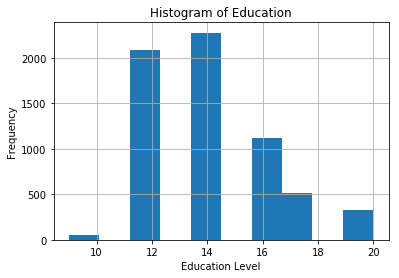

In [16]:
#histograms of education and marriage rating.


dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

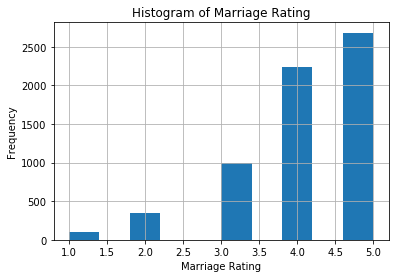

In [17]:
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

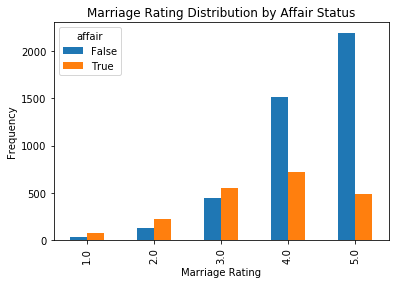

In [18]:
# look at the distribution of marriage ratings for those having affairs versus those not having affairs.


# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

In [23]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type="dataframe")
print( X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [24]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

##### need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.

In [26]:
# flatten y into a 1-D array
y = np.ravel(y)
y

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

#### Logistic Regression

In [27]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.72588752748978946

In [30]:
# what percentage had affairs?
y.mean()

0.32249450204209867

#### Model Evaluation Using a Validation Set

In [32]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print (predicted)

[ 1.  0.  0. ...,  0.  0.  0.]


In [36]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print (probs)

[[ 0.35142488  0.64857512]
 [ 0.90952576  0.09047424]
 [ 0.72576603  0.27423397]
 ..., 
 [ 0.55736751  0.44263249]
 [ 0.81213933  0.18786067]
 [ 0.74729595  0.25270405]]


### generate some evaluation metrics.



In [37]:
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))

0.729842931937
0.74596198609


In [38]:
print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))

[[1169  134]
 [ 382  225]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



### Model Evaluation Using Cross-Validation

In [40]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print (scores)
print (scores.mean())

[ 0.72100313  0.70219436  0.73824451  0.70597484  0.70597484  0.72955975
  0.7327044   0.70440252  0.75157233  0.75      ]
0.724163068551


In [41]:
model.predict_proba(np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4,
                              16]))

C:\Users\SHAIK NAWAAZ\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.7747227,  0.2252773]])